In [1]:
import numpy as np
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import csv
import cv2
import scipy
import os

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
num_classes = 4
epochs = 20
dropout =0.7
learning_rate = 0.001
# BASE_PATH = '/home/ec2-user/cell_classifier/'
BASE_DIR = '../'
batch_size = 32

In [3]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(240, 320, 3), output_shape=(240, 320, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(240, 320, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    rms = RMSprop(lr = learning_rate,)
    model.compile(loss='categorical_crossentropy',
                optimizer= rms,
                metrics=['accuracy'])

    return model

In [4]:
def get_data(folder):
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(240, 320, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [5]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST/')

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [6]:
model = get_model()

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('multiclass_3_layer_epochs'+str(epochs)+'_lr'+str(learning_rate)+'_dropout'+str(dropout)+'.h5')

Train on 7965 samples, validate on 1992 samples
Epoch 1/20
7965/7965 [==============================] - 92s - loss: 1.2858 - acc: 0.4050 - val_loss: 2.5996 - val_acc: 0.0000e+00
Epoch 2/20
7965/7965 [==============================] - 90s - loss: 0.9246 - acc: 0.6221 - val_loss: 2.4597 - val_acc: 0.0000e+00
Epoch 3/20
7965/7965 [==============================] - 89s - loss: 0.6699 - acc: 0.7422 - val_loss: 1.4691 - val_acc: 0.3544
Epoch 4/20
7965/7965 [==============================] - 96s - loss: 0.5163 - acc: 0.8143 - val_loss: 1.2126 - val_acc: 0.6551
Epoch 5/20
7965/7965 [==============================] - 92s - loss: 0.4356 - acc: 0.8374 - val_loss: 0.9885 - val_acc: 0.6717
Epoch 6/20
7965/7965 [==============================] - 93s - loss: 0.4030 - acc: 0.8703 - val_loss: 0.5810 - val_acc: 0.7575
Epoch 7/20
7965/7965 [==============================] - 95s - loss: 0.3223 - acc: 0.8849 - val_loss: 1.2917 - val_acc: 0.6852
Epoch 8/20
7965/7965 [==============================] - 93s - 

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 318, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 318, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 159, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 157, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 117, 157, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 78, 32)        0         
__________

In [8]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.879372738238842


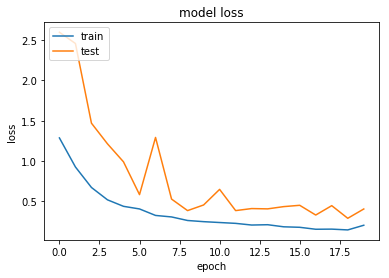

In [9]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve_multiclass.png')

plot_learning_curve(history)

In [10]:
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))

[[518   0   0 105]
 [  0 620   0   0]
 [  0   0 465 155]
 [ 39   1   0 584]]


In [11]:
from sklearn.metrics import precision_recall_fscore_support


precision,recall,fbeta_score,support = precision_recall_fscore_support(y_test_unencoded, y_pred_unencoded, average='macro')
print 'precision: '+ str(precision)
print 'recall: ' + str(recall)
print 'fbeta_score: ' + str(fbeta_score)
print 'support: '+ str(support)

precision: 0.9050787171706471
recall: 0.8793395275136848
fbeta_score: 0.8824858710101213
support: None
